# A simple example of Bayesian quadrature

Created by Zhuogang Peng (zpeng5@nd.edu)

These examples and codes were adapted from:

O’Hagan (1991) Bayes-Hermite Quadrature, Journal of Statistical Planning and Inference 29, pp. 245–260.

Diaconis, P. (1988). “Bayesian numerical analysis”. In:Statistical Decision Theory and Related Topics IV1,pp. 163–175.

The Emukit authors (2018), Emukit: Emulation and Uncertainty Quantification for Decision Making, https://github.com/amzn/emukit

McClarren, Ryan G (2018). Uncertainty Quantification and Predictive Computational Science: A Foundation for Physical Scientists and Engineers, Chapter 10 : Gaussian Process Emulators and Surrogate Models, Springer, https://link.springer.com/chapter/10.1007%2F978-3-319-99525-0_7


### Bayesian quadrature uses Gaussian process regression as the approximation to the integrand

* We want to calculate the integral
$$
F = \int_{\mathbb{D}}f(x)\mathrm{d}x.
$$
 

* Suppose we do not know the exact expression of $f$, but we do have some observations.

* The conventional method (like trapezoid rule) cannot give the accuracy of the integration. 

* But the Bayesian method estimates the uncertainty, along with the result. It can even tell us how to select the observations.

### The procedures of Bayesian Quadrature

* Using Gaussian process as a prior distribution of $f$.

* Observe $f$ at $[x_1, x_2, ..., x_n]$ on the computational domain $\mathbb{D}$.

* Calculate the posterior distribution of $f$ with Gaussian process regression.

* The integral $F$ is a linear functional of $f$.

* An important fact is that the posterior variance of F does not depend on $f$.


### Implementation

In [211]:
## import all needed Python libraries here
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import math
from scipy.stats import norm
from scipy.integrate import quad

# import sys
# !{sys.executable} -m pip install --user emukit
# !{sys.executable} -m pip install --user pyDOE

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C


# Figure config
LEGEND_SIZE = 16
FIGURE_SIZE = (10, 8)

For example, we are interested in 
the integral of 
$$
f(x) =  e^{-x^2-2 cos^2(x)} + 0.1sin(\frac{x}{2}).
$$
over $[-5, 5]$.


In [212]:
def f(x):
    return np.exp(-x**2 - 2*(np.cos(x))**2) + 0.1*np.sin(x/2)

In [213]:
benchmark_solution = quad(f, lb, ub)
print(benchmark_solution)

(0.5576405351796805, 2.7678712095935396e-13)


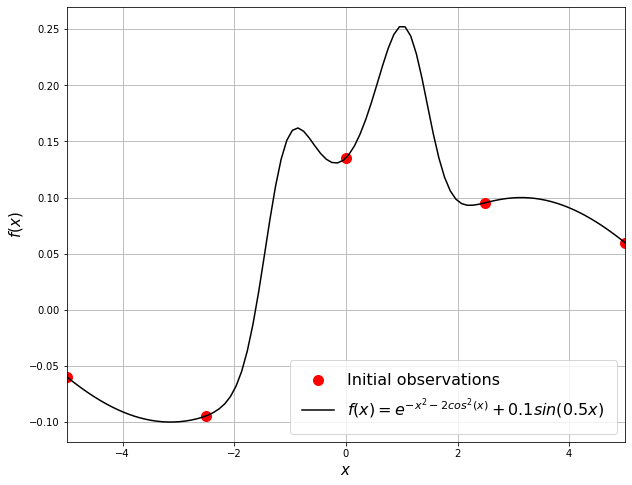

In [214]:
lb = -5 # lower bound
ub = 5 # upper bound

x_plot = np.linspace(lb, ub, 100)[:, None]

y_plot = f(x_plot)

X_init = np.linspace(-5, 5, 5)

Y_init = f(X_init)

plt.figure(figsize=FIGURE_SIZE)
plt.plot(X_init, Y_init, "ro", markersize=10, label="Initial observations")
plt.plot(x_plot, y_plot, "k", label="$f(x) =  e^{-x^2-2 cos^2(x)} + 0.1sin(0.5x)$")
plt.legend(loc='lower right', prop={'size': LEGEND_SIZE}, borderpad=0.8)
plt.xlabel(r"$x$", fontsize=15)
plt.ylabel(r"$f(x)$", fontsize=15)
plt.grid(True)
plt.xlim(lb, ub)
plt.show()


#### Fit the GPR model with scikit-learn and the squared-exponential kernel

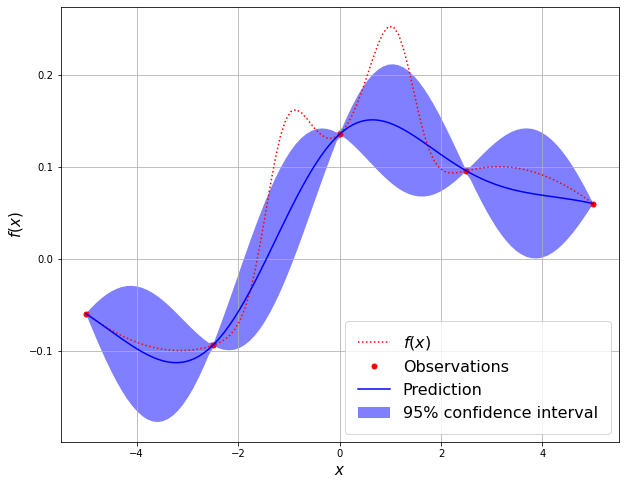

In [215]:
# Instantiate a Gaussian Process model

# n_restarts_optimizer: The number of restarts of the optimizer for finding the kernel’s parameters
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Fit to data using Maximum Likelihood Estimation of the parameters
X = np.atleast_2d(X_init).T

# Observations
y = f(X).ravel()

gpmodel = gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x_plot, return_std=True)

# x = np.atleast_2d(np.linspace(-3, 3, 300)).T

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure(figsize=FIGURE_SIZE)
plt.plot(x_plot, y_plot, 'r:', label=r'$f(x)$')
plt.plot(X, Y_init, 'r.', markersize=10, label='Observations')
plt.plot(x_plot, y_pred, 'b-', label='Prediction')
plt.fill(np.concatenate([x_plot, x_plot[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$', fontsize=15)
plt.ylabel('$f(x)$', fontsize=15)
plt.grid(True)
#plt.ylim(-0.1, 0.25)
plt.legend(loc='lower right', prop={'size': LEGEND_SIZE}, borderpad=0.8)

#### Take the GPR model as the surrogate

In [216]:
import GPy
X_init = X_init.reshape(-1,1)
Y_init = f(X_init)
gpy_model = GPy.models.GPRegression(X=X_init, Y=f(X_init), kernel=GPy.kern.RBF(
                        input_dim=X_init.shape[1], lengthscale=0.5, variance=1.0))

from emukit.model_wrappers.gpy_quadrature_wrappers import BaseGaussianProcessGPy, RBFGPy
from emukit.quadrature.kernels import QuadratureRBFLebesgueMeasure

emukit_rbf = RBFGPy(gpy_model.kern)
emukit_qrbf = QuadratureRBFLebesgueMeasure(emukit_rbf, integral_bounds=[[lb, ub]])
emukit_model = BaseGaussianProcessGPy(kern=emukit_qrbf, gpy_model=gpy_model)

### Result

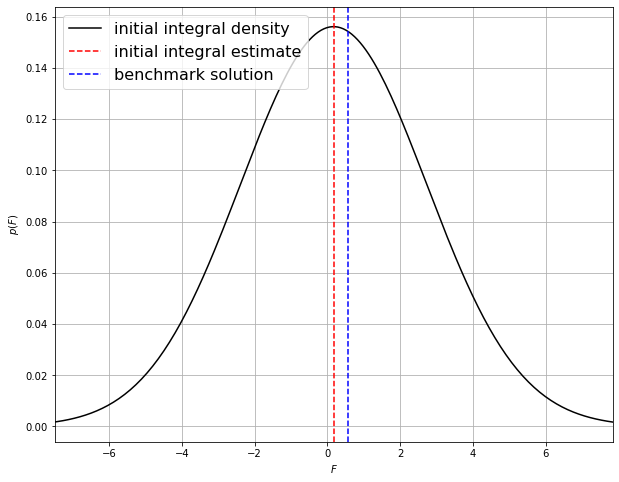

The initial estimated integral is:  0.17
with a confidence interval:  5.11 .
The ground truth rounded to 2 digits for comparison is:  0.56 .


In [217]:
from emukit.quadrature.methods import VanillaBayesianQuadrature

emukit_method = VanillaBayesianQuadrature(base_gp=emukit_model, X=X_init, Y=Y_init)

initial_integral_mean, initial_integral_variance = emukit_method.integrate()

x_plot_integral = np.linspace(initial_integral_mean-3*np.sqrt(initial_integral_variance), 
                              initial_integral_mean+3*np.sqrt(initial_integral_variance), 200)
y_plot_integral_initial = 1/np.sqrt(initial_integral_variance * 2 * np.pi) * \
np.exp( - (x_plot_integral - initial_integral_mean)**2 / (2 * initial_integral_variance) )
plt.figure(figsize=FIGURE_SIZE)
plt.plot(x_plot_integral, y_plot_integral_initial, "k", label="initial integral density")
plt.axvline(initial_integral_mean, color="red", label="initial integral estimate", \
            linestyle="--")
plt.axvline(analytical_solution[0], color="blue", label="benchmark solution", linestyle="--")
plt.legend(loc=2, prop={'size': LEGEND_SIZE})
plt.xlabel(r"$F$")
plt.ylabel(r"$p(F)$")
plt.grid(True)
plt.xlim(np.min(x_plot_integral), np.max(x_plot_integral))
plt.show()

print('The initial estimated integral is: ', round(initial_integral_mean, 2))
print('with a confidence interval: ', round(2*np.sqrt(initial_integral_variance), 2), '.')
print('The ground truth rounded to 2 digits for comparison is: ', round(analytical_solution[0], 2), '.')

#### Find the next quadrature point

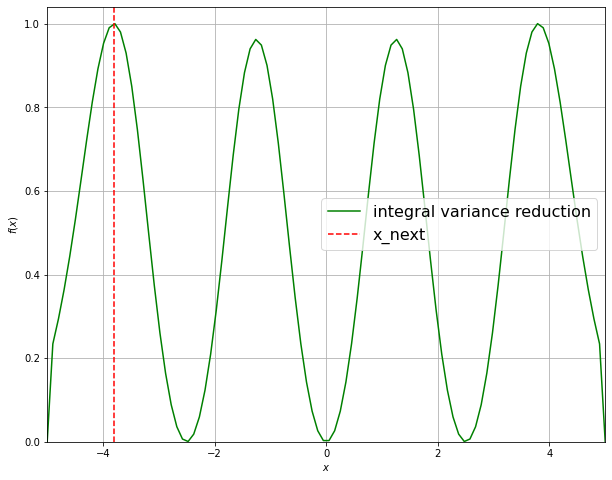

In [218]:
from emukit.quadrature.acquisitions import IntegralVarianceReduction

ivr_acquisition = IntegralVarianceReduction(emukit_method)

ivr_plot = ivr_acquisition.evaluate(x_plot)

from emukit.core.optimization import GradientAcquisitionOptimizer
from emukit.core.parameter_space import ParameterSpace

space = ParameterSpace(emukit_method.reasonable_box_bounds.convert_to_list_of_continuous_parameters())
optimizer = GradientAcquisitionOptimizer(space)
x_new,_ = optimizer.optimize(ivr_acquisition)

plt.figure(figsize=FIGURE_SIZE)
plt.plot(x_plot, (ivr_plot - np.min(ivr_plot)) / (np.max(ivr_plot) - np.min(ivr_plot)), 
         "green", label="integral variance reduction")
plt.axvline(x_new, color="red", label="x_next", linestyle="--")
plt.legend(loc=0, prop={'size': LEGEND_SIZE})
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.grid(True)
plt.xlim(lb, ub)
plt.ylim(0, 1.04)
plt.show()

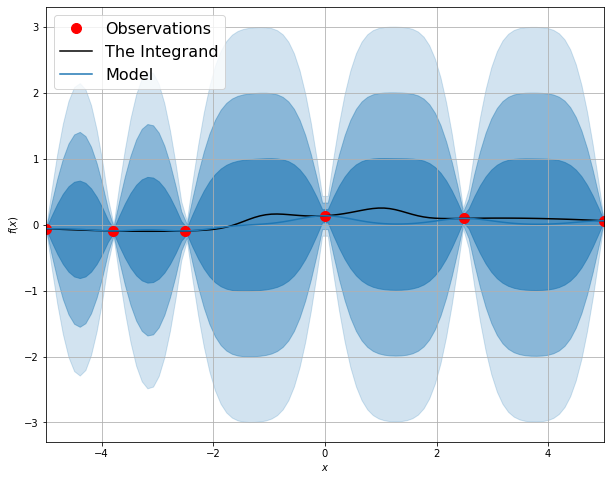

In [219]:
y_new = f(x_new)
X = np.append(X_init, x_new, axis=0)
Y = np.append(Y_init, y_new, axis=0)

emukit_method.set_data(X, Y)

mu_plot, var_plot = emukit_model.predict(x_plot)

plt.figure(figsize=FIGURE_SIZE)
plt.plot(emukit_model.X, emukit_model.Y, "ro", markersize=10, label="Observations")
plt.plot(x_plot, y_plot, "k", label="The Integrand")
plt.plot(x_plot, mu_plot, "C0", label="Model")
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color="C0", alpha=0.6)
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 2 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 2 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.4)
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 3 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 3 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.2)
plt.legend(loc=2, prop={'size': LEGEND_SIZE})
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.grid(True)
plt.xlim(lb, ub)
plt.show()

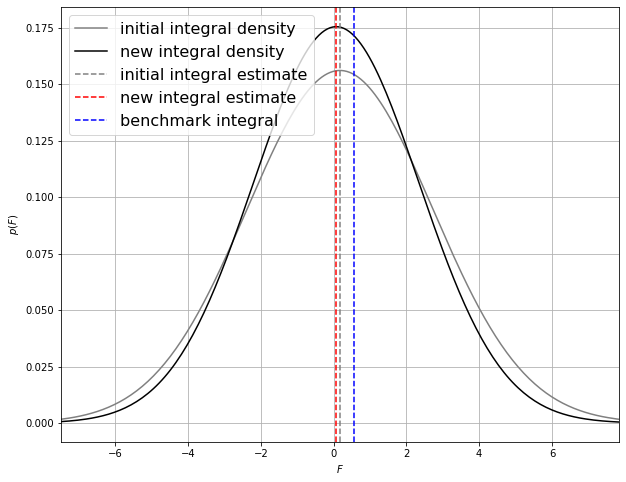

The initial estimated integral is:  0.17
with a confidence interval:  5.11 .
The second estimated integral is:  0.07
with a confidence interval:  4.55 .
The benchmark solution rounded with 2 digits is:  0.56 .


In [220]:
integral_mean, integral_variance = emukit_method.integrate()
y_plot_integral = 1/np.sqrt(integral_variance * 2 * np.pi) * \
np.exp( - (x_plot_integral - integral_mean)**2 / (2 * integral_variance) )
plt.figure(figsize=FIGURE_SIZE)
plt.plot(x_plot_integral, y_plot_integral_initial, "gray", label="initial integral density")
plt.plot(x_plot_integral, y_plot_integral, "k", label="new integral density")
plt.axvline(initial_integral_mean, color="gray", label="initial integral estimate", linestyle="--")
plt.axvline(integral_mean, color="red", label="new integral estimate", linestyle="--")
plt.axvline(benchmark_solution[0], color="blue", label="benchmark integral", \
            linestyle="--")
plt.legend(loc=2, prop={'size': LEGEND_SIZE})
plt.xlabel(r"$F$")
plt.ylabel(r"$p(F)$")
plt.grid(True)
plt.xlim(np.min(x_plot_integral), np.max(x_plot_integral))
plt.show()
print('The initial estimated integral is: ', round(initial_integral_mean, 2))
print('with a confidence interval: ', round(2*np.sqrt(initial_integral_variance), 2), '.')
print('The second estimated integral is: ', round(integral_mean, 2))
print('with a confidence interval: ', round(2*np.sqrt(integral_variance), 2), '.')
print('The benchmark solution rounded with 2 digits is: ', round(benchmark_solution[0], 2), '.')